<a href="https://colab.research.google.com/github/mattbev/robot-juggler/blob/main/Robot_Juggling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**I recommend you run the first code cell of this notebook immediately, to start provisioning drake on the cloud machine, then you can leave this window open as you [read the textbook](manipulation.csail.mit.edu/robot.html).**

# Notebook setup

The following cell will:
- on Colab (only), install Drake to `/opt/drake`, install Drake's prerequisites via `apt`, and add pydrake to `sys.path`.  This will take approximately two minutes on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  If you navigate between notebooks using Colab's "File->Open" menu, then you can avoid provisioning a separate machine for each notebook.
- launch a server for our 3D visualizer (MeshCat) that will be used for the remainder of this notebook.

You will need to rerun this cell if you restart the kernel, but it should be fast because the machine will already have drake installed.

In [ ]:
import importlib
import sys
from urllib.request import urlretrieve

if 'google.colab' in sys.modules and importlib.util.find_spec('pydrake') is None:
  version='20200918'
  build='nightly'
  urlretrieve(f"https://drake-packages.csail.mit.edu/drake/{build}/drake-{version}/setup_drake_colab.py",
              "setup_drake_colab.py")
  from setup_drake_colab import setup_drake
  setup_drake(version=version, build=build)
  !pip install pyngrok==4.2.2

# Install pyngrok.
server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']

# Start a single meshcat server instance to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

# Determine if this notebook is currently running as a notebook or a unit test.
from IPython import get_ipython
running_as_notebook = get_ipython() and hasattr(get_ipython(), 'kernel')

# Imports
import numpy as np
import pydot
from ipywidgets import Dropdown, Layout
from IPython.display import display, HTML, SVG

from pydrake.all import (
    AddMultibodyPlantSceneGraph, ConnectMeshcatVisualizer, DiagramBuilder, 
    FindResourceOrThrow, GenerateHtml, InverseDynamicsController, 
    MultibodyPlant, Parser, Simulator)
from pydrake.multibody.jupyter_widgets import MakeJointSlidersThatPublishOnCallback


# KUKA iiwa arm


In [ ]:
builder = DiagramBuilder()

plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
Parser(plant, scene_graph).AddModelFromFile(FindResourceOrThrow("drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf"))
plant.Finalize()

meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)
diagram = builder.Build()
context = diagram.CreateDefaultContext()

meshcat.load()
MakeJointSlidersThatPublishOnCallback(plant, meshcat, context);

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://fe417f1d3cf4.ngrok.io/static/
Connected to meshcat-server.


FloatSlider(value=0.0, description='iiwa_joint_1', layout=Layout(width="'200'"), max=2.96706, min=-2.96706, st…

FloatSlider(value=0.0, description='iiwa_joint_2', layout=Layout(width="'200'"), max=2.0944, min=-2.0944, step…

FloatSlider(value=0.0, description='iiwa_joint_3', layout=Layout(width="'200'"), max=2.96706, min=-2.96706, st…

FloatSlider(value=0.0, description='iiwa_joint_4', layout=Layout(width="'200'"), max=2.0944, min=-2.0944, step…

FloatSlider(value=0.0, description='iiwa_joint_5', layout=Layout(width="'200'"), max=2.96706, min=-2.96706, st…

FloatSlider(value=0.0, description='iiwa_joint_6', layout=Layout(width="'200'"), max=2.0944, min=-2.0944, step…

FloatSlider(value=0.0, description='iiwa_joint_7', layout=Layout(width="'200'"), max=3.05433, min=-3.05433, st…

# Simulation with block diagrams

In this chapter, and throughout the notes, we will be building up our simulations and controllers using drake's block diagram modeling language (we call it the "systems framework").  [This tutorial](https://mybinder.org/v2/gh/RobotLocomotion/drake/nightly-release?filepath=tutorials/dynamical_systems.ipynb)  provides a brief introduction.  


# Simulating the (passive) iiwa

Let's load our robot of choice (the Kuka iiwa) into the physics engine, which we call [MultibodyPlant](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_multibody_plant.html).


In [ ]:
plant = MultibodyPlant(time_step=1e-4)
Parser(plant).AddModelFromFile(
        FindResourceOrThrow("drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf"))
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
plant.Finalize()

In Drake, we are very careful to separate the *state* of a system from the system itself.  For example, let's think of a dynamical system as given by the difference equation: $$x[n+1] = f(n, x[n], u[n]),$$ where $n$ is the "time", $x$ is the state, and $u$ is any inputs to the system.  The `System` describes $f()$, but we use a structure called the [`Context`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_context.html) to hold the runtime values: $n, x, u$.  We use a structure, because some systems have even more runtime values, that describe system parameters, random noise inputs, etc, and it is cleaner to pass a structure around than have each system accept a different list of possible inputs.  As a rule `System` is constant over the duration of a simulation, and you should be able to obtain repeatable, deterministic simulations given any value `Context`.

Let's see what the `Context` looks like for the physics engine now that we've loaded the iiwa into it.

In [ ]:
context = plant.CreateDefaultContext()
print(context)

::_ Context
------------
Time: 0
States:
  1 discrete state groups with
     14 states
       0 0 0 0 0 0 0 0 0 0 0 0 0 0

Parameters:
  9 numeric parameter groups with
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
            5   -0.1      0   0.07 0.0149 0.0269  0.016      0  0.007      0
     10 parameters
             5.76          0      -0.03       0.12  0.0210292  0.0201812 0.00303542          0          0     0.0036
     10 parameters
             6.35     0.0003      0.059      0.042  0.0100481 0.00655149 0.00521337  -1.77e-05  -1.26e-05  -0.002478
     10 parameters
              3.5          0       0.03       0.13  0.0249429     0.0237 0.00307143          0          0    -0.0039
     10 parameters
              3.5          0      0.067      0.034  0.0105021 0.00584171 0.00620329          0          0  -0.002278
     10 parameters
              3.5     0.0001      0.021      0.076 0.00907414 0.00826172 0.00172387   -2.1e-06   -7.6e-06 

The system has 14 state variables -- these are the 7 joint positions and 7 joint velocities for the iiwa.  Those states are discrete, because we passed a non-zero `time_step` to the constructor of the `MultibodyPlant`, which means the physics engine will be use a time-stepping simulation scheme (this will be the most performant when we start simulating contact).  Go ahead and try changing `time_step` to zero, and see what happens.

You'll notice the context has lots of parameters (currently these include the mass, the center of mass, and the inertia of each body).  You won't need those any time soon, but it does enable some super cool advanced features.

Because the `Context` for a `MultibodyPlant` can get quite complicated, `MultibodyPlant` offers some methods that help you get/set the values.  Let's set some non-zero initial positions.

In [ ]:
# Set all of the joint positions at once in a single vector.
plant.SetPositions(context, [-1.57, 0.1, 0, 0, 0, 1.6, 0])
# You can also set them by referencing particular joints.
plant.GetJointByName("iiwa_joint_4").set_angle(context, -1.2)
print(context)

::_ Context
------------
Time: 0
States:
  1 discrete state groups with
     14 states
       -1.57   0.1     0  -1.2     0   1.6     0     0     0     0     0     0     0     0

Parameters:
  9 numeric parameter groups with
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
            5   -0.1      0   0.07 0.0149 0.0269  0.016      0  0.007      0
     10 parameters
             5.76          0      -0.03       0.12  0.0210292  0.0201812 0.00303542          0          0     0.0036
     10 parameters
             6.35     0.0003      0.059      0.042  0.0100481 0.00655149 0.00521337  -1.77e-05  -1.26e-05  -0.002478
     10 parameters
              3.5          0       0.03       0.13  0.0249429     0.0237 0.00307143          0          0    -0.0039
     10 parameters
              3.5          0      0.067      0.034  0.0105021 0.00584171 0.00620329          0          0  -0.002278
     10 parameters
              3.5     0.0001      0.021      0.076

The iiwa model also defined 7 actuators.  Before we can run a simulation, we need to provide some values for those inputs to the `MultibodyPlant` `actuation_input_port`.  For this warm-up, we'll just set them to zero.

In [ ]:
plant.get_actuation_input_port().FixValue(context, np.zeros(7));

Now we can set up and run a simulation.

In [ ]:
simulator = Simulator(plant, context)
simulator.AdvanceTo(5.0)
print(context)

::_ Context
------------
Time: 5
States:
  1 discrete state groups with
     14 states
          -1.53093     2.09596  -0.0164211   -0.689524     2.92046    0.808647   -0.267658   -0.105249 -0.00676799    0.221191     4.05478   -0.934069     3.10075     7.11648

Parameters:
  9 numeric parameter groups with
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
            5   -0.1      0   0.07 0.0149 0.0269  0.016      0  0.007      0
     10 parameters
             5.76          0      -0.03       0.12  0.0210292  0.0201812 0.00303542          0          0     0.0036
     10 parameters
             6.35     0.0003      0.059      0.042  0.0100481 0.00655149 0.00521337  -1.77e-05  -1.26e-05  -0.002478
     10 parameters
              3.5          0       0.03       0.13  0.0249429     0.0237 0.00307143          0          0    -0.0039
     10 parameters
              3.5          0      0.067      0.034  0.0105021 0.00584171 0.00620329          0        

# Visualizing the scene

The best way to visualize the results of a physics engine is with a 2D or 3D visualizer. For that, we need to add the system which curates the geometry of a scene (the geometry engine); in Drake with call it the [`SceneGraph`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1geometry_1_1_scene_graph.html). Once we have a `SceneGraph`, then there are a number of different visualizers and sensors that we can add to the system to actually render the scene.

We support a number of visualizers in drake (we ship a simple VTK-based "drake-visualizer" with our binary releases, or you can use RViz).  But because we're working in a jupyter notebook, and want you to be able to run 3D graphics on any machine without any installation required, we'll use the [MeshCat](https://github.com/rdeits/meshcat) visualizer throughout these notes.  

To use all three systems (`MultibodyPlant`, `SceneGraph`, and `MeshcatVisualizer`), we need to assemble them into a [`Diagram`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_diagram.html) using a [`DiagramBuilder`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_diagram_builder.html).  Often you would add each system and then connect the ports together, but for common cases like we have here, we provide helper methods to reduce the boilerplate.

In [ ]:
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
Parser(plant, scene_graph).AddModelFromFile(
        FindResourceOrThrow("drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf"))
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)

diagram = builder.Build()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://5e52e9bb4ee4.ngrok.io/static/
Connected to meshcat-server.


If you click on the link above, you can open a browser window to see the visualization.

But the scene will be empty so far.  We need to actually construct the diagram and ask it to publish.  (You normally don't have to call these; MeshcatVisualizer will automatically load at initialization and publish on a fixed period during simulation).

In [ ]:
context = diagram.CreateDefaultContext()
meshcat.load()
diagram.Publish(context)

We've put together quite a complex system now.  A `Diagram` is just another `System`, so it has an associated context.

In [ ]:
print(context)

::_ Context (of a Diagram)
---------------------------
14 total discrete states in 1 groups
1 total abstract states
90 total numeric parameters in 9 groups

::_::plant Context
-------------------
Time: 0
States:
  1 discrete state groups with
     14 states
       0 0 0 0 0 0 0 0 0 0 0 0 0 0

Parameters:
  9 numeric parameter groups with
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
            5   -0.1      0   0.07 0.0149 0.0269  0.016      0  0.007      0
     10 parameters
             5.76          0      -0.03       0.12  0.0210292  0.0201812 0.00303542          0          0     0.0036
     10 parameters
             6.35     0.0003      0.059      0.042  0.0100481 0.00655149 0.00521337  -1.77e-05  -1.26e-05  -0.002478
     10 parameters
              3.5          0       0.03       0.13  0.0249429     0.0237 0.00307143          0          0    -0.0039
     10 parameters
              3.5          0      0.067      0.034  0.0105021 0.0058417

You can see that there is one additional "abstract state" from the `SceneGraph`.  `MeshcatVisualizer` is stateless.  Actually `SceneGraph` should really be stateless for these simple examples, too [#9501](https://github.com/RobotLocomotion/drake/issues/9501).

It's also very useful to draw the actual block diagram.

There is one more important detail: **The `Context` for the `Diagram` is not the `Context` of the `MultibodyPlant`**.  But you can extract the plant `Context`; and we need to in order to set the initial conditions of the robot.

In [ ]:
plant_context = plant.GetMyMutableContextFromRoot(context)
plant.SetPositions(plant_context, [-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
plant.get_actuation_input_port().FixValue(plant_context, np.zeros(7))
print(context)

::_ Context (of a Diagram)
---------------------------
14 total discrete states in 1 groups
1 total abstract states
90 total numeric parameters in 9 groups

::_::plant Context
-------------------
Time: 0
States:
  1 discrete state groups with
     14 states
       -1.57   0.1     0  -1.2     0   1.6     0     0     0     0     0     0     0     0

Parameters:
  9 numeric parameter groups with
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
            5   -0.1      0   0.07 0.0149 0.0269  0.016      0  0.007      0
     10 parameters
             5.76          0      -0.03       0.12  0.0210292  0.0201812 0.00303542          0          0     0.0036
     10 parameters
             6.35     0.0003      0.059      0.042  0.0100481 0.00655149 0.00521337  -1.77e-05  -1.26e-05  -0.002478
     10 parameters
              3.5          0       0.03       0.13  0.0249429     0.0237 0.00307143          0          0    -0.0039
     10 parameters
              3

Accidentally using `context` instead of `plant_context` is a very common mistake!

Ok, now we're ready to simulate.  Make sure your visualizer window is visible, then run the following cell.

In [ ]:
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(5.0 if running_as_notebook else 0.1)

RuntimeError: ignored

Glorious!

Here's one more trick.  You can ask MeshCat to record the animation, and then review it in the visualizer.  I'll repeat the preamble here to make this cell stand-alone.  (Plus we cannot reuse a system in multiple diagrams; the ownership is restricted).

In [ ]:
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
Parser(plant, scene_graph).AddModelFromFile(
        FindResourceOrThrow("drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf"))
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, delete_prefix_on_load=False)

diagram = builder.Build()
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
plant.SetPositions(plant_context, [-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
plant.get_actuation_input_port().FixValue(plant_context, np.zeros(7))

simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)

meshcat.start_recording()
simulator.AdvanceTo(5.0 if running_as_notebook else 0.1)
meshcat.stop_recording()
meshcat.publish_recording()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://95385f1d8fb2.ngrok.io/static/
Connected to meshcat-server.


# Adding the iiwa controller

The iiwa hardware interface runs through a control system provided by the manufacturer.  We can't turn it off.  The best we can do is add our approximation of it to our simulation.  I'll repeat everything we've set up before (to keep this example self-contained), but we'll add one more system for the controller.

In [ ]:
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
iiwa_model = Parser(plant, scene_graph).AddModelFromFile(
        FindResourceOrThrow("drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf"))
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, delete_prefix_on_load=False)

# Adds an approximation of the iiwa controller.
# TODO(russt): replace this with the joint impedance controller.
Kp = np.full(7, 100)
Ki = 2 * np.sqrt(Kp)
Kd = np.full(7, 1)
iiwa_controller = builder.AddSystem(InverseDynamicsController(plant, Kp, Ki, Kd, False))
iiwa_controller.set_name("iiwa_controller");
builder.Connect(plant.get_state_output_port(iiwa_model),
                iiwa_controller.get_input_port_estimated_state())
builder.Connect(iiwa_controller.get_output_port_control(),
                plant.get_actuation_input_port())
diagram = builder.Build()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://95385f1d8fb2.ngrok.io/static/
Connected to meshcat-server.


Let's see what our diagram looks like...

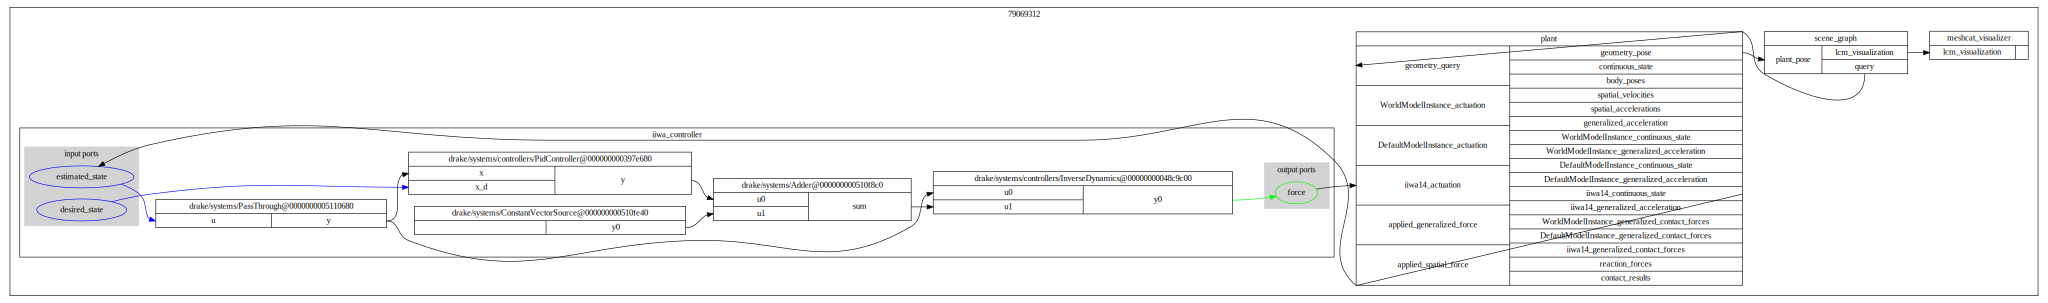

In [ ]:
SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())

As our diagrams get more complex, we're going to need a better approach to rendering the diagrams.  I've got a rough first pass (that it still suffering from some licensing issues) in javascript that I aim to improve.

TODO(russt): Update the javascript rendering [#13874](https://github.com/RobotLocomotion/drake/issues/13874).  

In [ ]:
diagram.set_name("diagram")
HTML('<script src="https://unpkg.com/gojs/release/go.js"></script>' + GenerateHtml(diagram))

To set up the `Context` now, instead of setting the `actuation_input` to zero, we set the `desired_state` of the iiwa controller to be the current position of the arm.  But the desired *state* must also include desired velocities, so we set those to zero.

In [ ]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
x0 = np.hstack((q0, 0*q0))
plant.SetPositions(plant_context, q0)
iiwa_controller.GetInputPort('desired_state').FixValue(
    iiwa_controller.GetMyMutableContextFromRoot(context), x0)
print(context)

::diagram Context (of a Diagram)
---------------------------------
7 total continuous states
14 total discrete states in 1 groups
1 total abstract states
97 total numeric parameters in 10 groups

::diagram::plant Context
-------------------------
Time: 0
States:
  1 discrete state groups with
     14 states
       -1.57   0.1     0  -1.2     0   1.6     0     0     0     0     0     0     0     0

Parameters:
  9 numeric parameter groups with
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
            5   -0.1      0   0.07 0.0149 0.0269  0.016      0  0.007      0
     10 parameters
             5.76          0      -0.03       0.12  0.0210292  0.0201812 0.00303542          0          0     0.0036
     10 parameters
             6.35     0.0003      0.059      0.042  0.0100481 0.00655149 0.00521337  -1.77e-05  -1.26e-05  -0.002478
     10 parameters
              3.5          0       0.03       0.13  0.0249429     0.0237 0.00307143          0      

Now, if we simulate, the robot just stays put.  Just like the real robot would.

In [ ]:
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0);
simulator.AdvanceTo(5.0 if running_as_notebook else 0.1);

# Robot hands

I don't have the same smörgåsbord of robot models to offer for robot hands (yet).  We do have the allegro hand model available, and I'm happy to add more here (though many will require some care to handle their kinematic constraints).  For now, you can at least try out the [Allegro Hand](http://www.wonikrobotics.com/Allegro-Hand.htm).

TODO(russt): Consider porting Robotiq, Sandia, or IHY-hand from our [openhumanoids](https://github.com/openhumanoids/oh-distro/tree/master/software/models/common_components) project.

In [ ]:
builder = DiagramBuilder()

plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
allegro_file = FindResourceOrThrow("drake/manipulation/models/allegro_hand_description/sdf/allegro_hand_description_right.sdf")
Parser(plant, scene_graph).AddModelFromFile(allegro_file)
plant.Finalize()

meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)
diagram = builder.Build()
context = diagram.CreateDefaultContext()

meshcat.load()
MakeJointSlidersThatPublishOnCallback(plant, meshcat, context);